# P3 Computational Vision

**Important:** Read the file `README.md` before start coding.

<div class = "alert alert-info" style = "border-radius:10px;border-width:3px;border-color:darkblue;font-family:Verdana,sans-serif;font-size:16px;">

**Delivery**
<ol>

Requirements to fulfill:
<ul>
    <li>  Answer the questions introduced in the exercises.   
    <li>  The implemented code should be,<br>
        - optimized ( e.g. do not use 'for' instruction when indexing numpy arrays)<br>
        - readable  ( e.g. avoiding the implementation of more than 2 loops within a line)<br>
        - commented and with descriptions        
    <li> Add title to the figures to explain what is displayed.
    <li> The deliverable must be a file named **P4_Student1_Student2.zip** that includes:
    <ul>
        <li> The notebook P4_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    </ul>

</ul>

 **Deadline (Campus Virtual): October 28th, 23:00 h** 


</ol>
</div>


## Practicum 3: Descriptors extraction for person detection based on HOG


In this laboratory we will treat the following topic: HOG image descriptor. Application to object (person) detection.

It is highly recommendable to structure the code in functions in order to reuse code for different tests and images and make it shorter and more readable. 

In [1]:
import math

import skimage.io as io
import skimage.feature as feature
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from glob import glob
from math import ceil
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.exposure import rescale_intensity

import numpy as np

%matplotlib inline

# Histogram of Oriented Gradients


The Histogram of Oriented Gradients (HOG) feature descriptor is classical image descriptor for object detection.

Given the image 'person_template.bmp' and the folder '/images/TestPersonImages/', apply the HOG descriptor in order to detect where there is a person in the images. To this purpose, apply the "sliding window" technique. We use images from GRAZ 01 data from [INRIA datasets](http://pascal.inrialpes.fr/data/human/).

**Exercise 1.** Read the template ('person_template.bmp'), obtain its HOG descriptor (with the optimal parameters) and visualize it.

Help: the HOG detector function is in the skimage.feature library ([Help](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html#sphx-glr-auto-examples-features-detection-plot-hog-py)).


In [7]:
ORIENTATIONS = 16
PIXELS_PER_CELL = (2, 2)
CELLS_PER_BLOCK = (1, 1)

RGB = True
GAU = False

def _hog(img, rgb=True, gau=False):
    if not rgb:
        img = rgb2gray(img)
    if gau:
        img = gaussian(img, multichannel=rgb)

    _, hog_img = feature.hog(img,
                             orientations=ORIENTATIONS,
                             pixels_per_cell=PIXELS_PER_CELL,
                             cells_per_block=CELLS_PER_BLOCK,
                             block_norm='L2-Hys',
                             visualize=True, multichannel=rgb)
    return hog_img

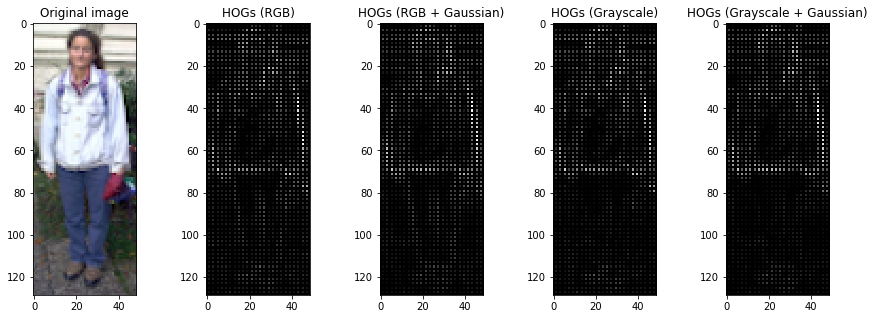

In [8]:
person = io.imread('images/person_template.bmp')

hog_person = _hog(person)
hog_person_ga = _hog(person, gau=True)
hog_person_bw = _hog(person, rgb=False)
hog_person_bw_ga = _hog(person, rgb=False, gau=True)

f, ax = plt.subplots(1, 5, figsize=(15, 5))

ax[0].imshow(person)
ax[0].set_title('Original image')

ax[1].imshow(hog_person, cmap='gray')
ax[1].set_title('HOGs (RGB)')

ax[2].imshow(hog_person_ga, cmap='gray')
ax[2].set_title('HOGs (RGB + Gaussian)')

ax[3].imshow(hog_person_bw, cmap='gray')
ax[3].set_title('HOGs (Grayscale)')

ax[4].imshow(hog_person_bw_ga, cmap='gray')
ax[4].set_title('HOGs (Grayscale + Gaussian)')

plt.show()

In [9]:
hog_person = _hog(person, rgb=RGB, gau=GAU)

**Exercise 2.** Apply the HOG descriptor on the complete set of images for person detection.

a) Read images from the folder "TestPersonImages", slide a window on each image, obtain the HOG descriptor and compare to the HOG descriptor of the person template.

b) Visualize the location in the image that is the most similar to the person template using the distance between the template and test image descriptors.

Display the results of every person detection following this format:

<img src="images/hog.png" width="800" height="100">

In [10]:
def slide_window(image, template, stride=1, distance_fun='euclidean'):
    assert distance_fun in ['euclidean', 'dot']
    ih, iw = image.shape[0:2]
    th, tw = template.shape[0:2]
    
    best_i = 0
    best_j = 0
    best_distance = math.inf
    
    hog_image = _hog(person, rgb=RGB, gau=GAU)
    
    for i in range(0, ih - th, stride):
        for j in range(0, iw - tw, stride):
            hog_window = hog_image[i:i + th, j:j + tw]
            
            if distance_fun == 'euclidean':
                distance = np.linalg.norm(hog_person - hog_window)
            else:
                distance = np.tensordot(hog_person, hog_window)        
            
            if distance < best_distance:
                best_i = i
                best_j = j
                best_distance = distance
                
    rect = patches.Rectangle((best_j, best_i), tw, th, linewidth=1, edgecolor='red', facecolor='none')
    return rect, hog_image

ValueError: operands could not be broadcast together with shapes (129,49) (129,44) 

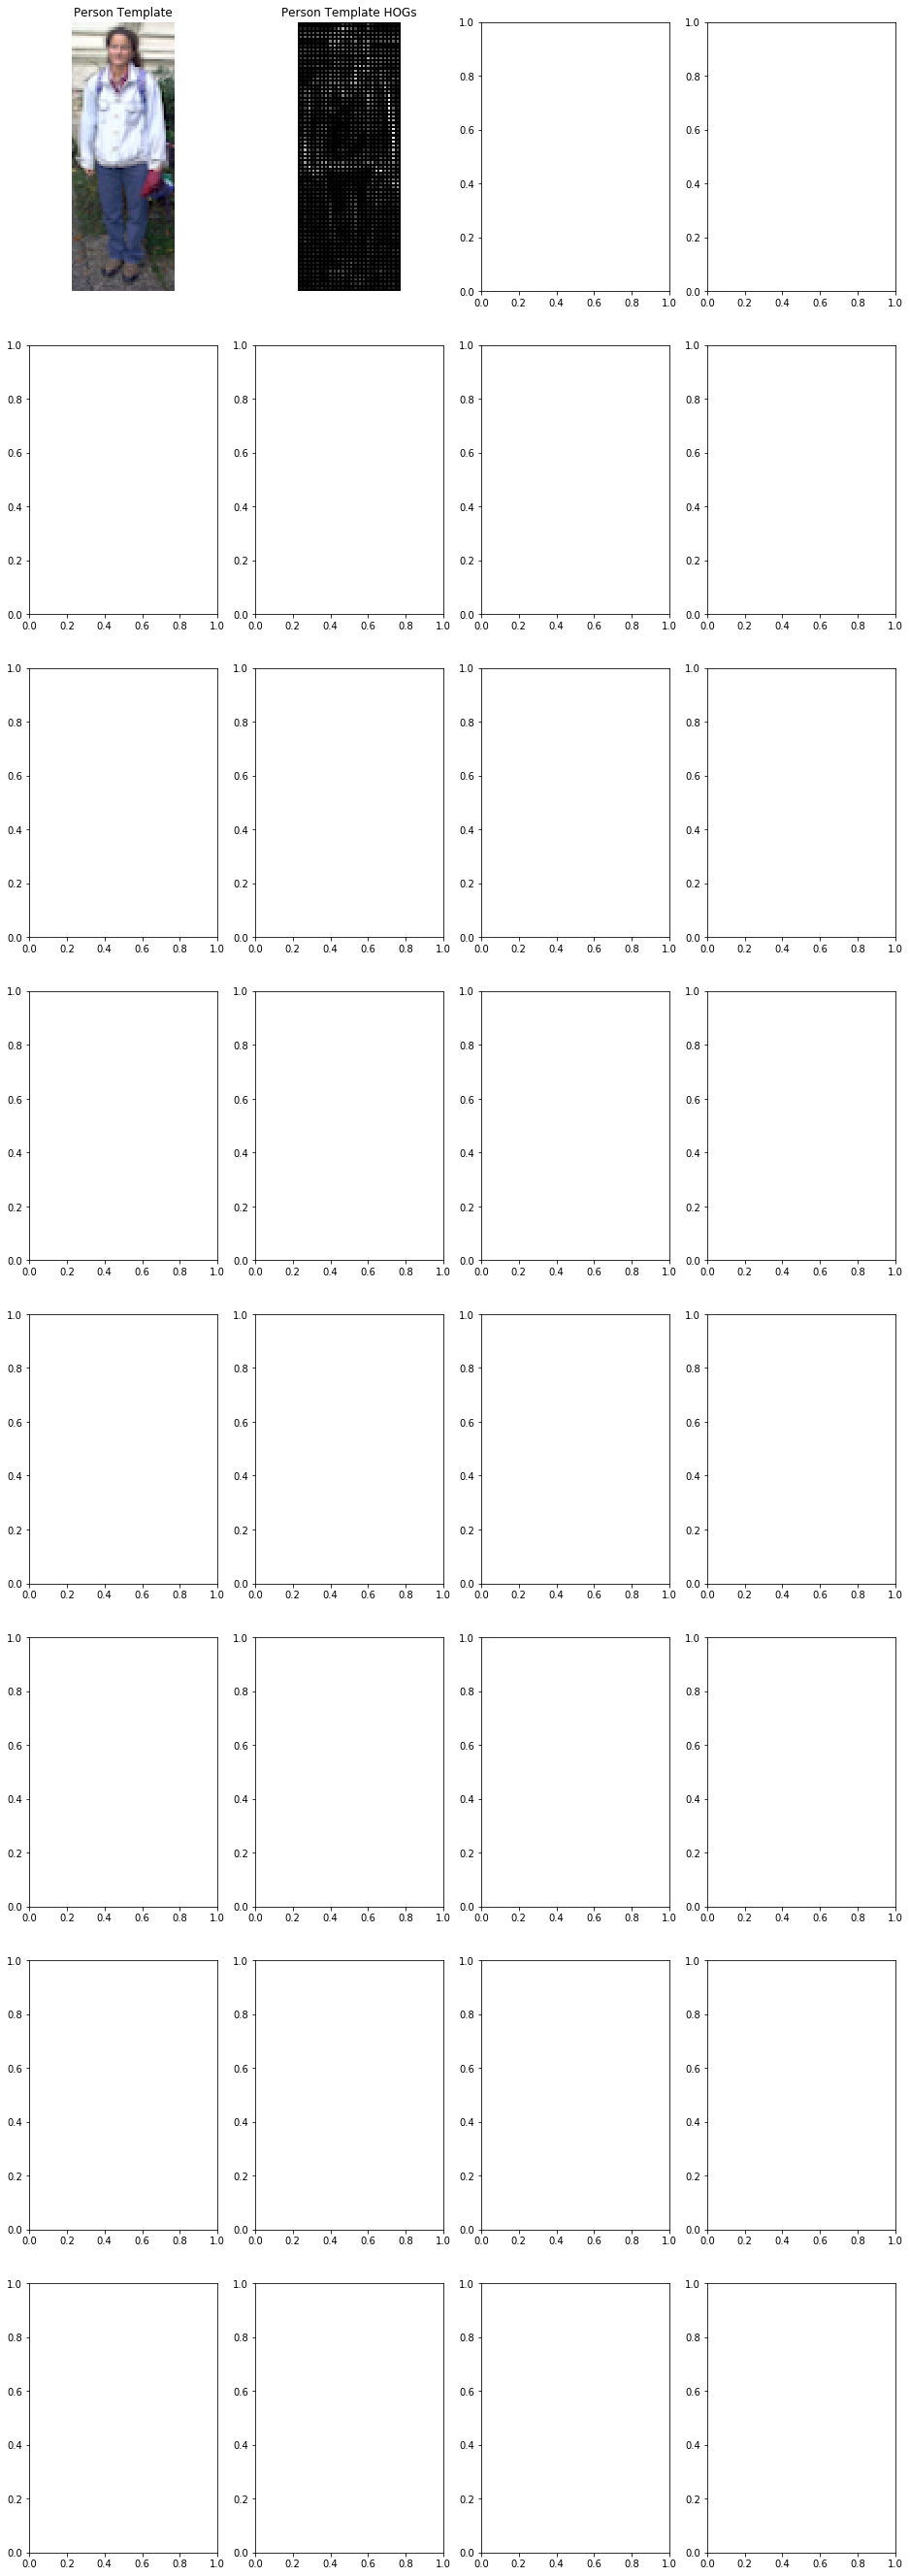

In [11]:
test_images_paths = sorted(glob('images/TestPersonImages/*.bmp'))
rows = ceil(len(test_images_paths) / 2)
cols = 4

f, ax = plt.subplots(rows, cols, figsize=(cols * 4, rows * 6))

ax[0][0].imshow(person)
ax[0][0].set_title('Person Template')
ax[0][0].axis('off')

ax[0][1].imshow(hog_person, cmap='gray')
ax[0][1].set_title('Person Template HOGs')
ax[0][1].axis('off')

for idx, img_path in enumerate(test_images_paths, start=1):
    img_id = img_path[32:34]
    img = io.imread(img_path)
    rect, hog_window = slide_window(img, person, stride=5)
    
    ax[idx // 2][(idx % 2)*2].imshow(img)
    
    ax[idx // 2][(idx % 2)*2].axis('off')
    ax[idx // 2][(idx % 2)*2].set_title(f'Best Region Match ({img_id})')
    ax[idx // 2][(idx % 2)*2].add_patch(rect)
    
    ax[idx // 2][(idx % 2)*2 + 1].imshow(hog_window, cmap='gray')
    ax[idx // 2][(idx % 2)*2 + 1].axis('off')
    ax[idx // 2][(idx % 2)*2 + 1].set_title(f'HOG Distances ({img_id})')
    
plt.axis('off')
plt.show()

**Exercise 3.** 
- Count on how many images were the persons detected correctly and discuss the failures. What do you think can be the reasons for the failures?
- Discuss what are the parameters of the HOG algorithm. Test several values of the parameters up to your criterion to show which are the optimal values for the person detection problem.
- Discuss which distance between template and test images have you used and why. Euclidean or dot distance?

<div class = "alert alert-info" style = "background-color:Wheat;border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">

</div>